In [3]:
import os
import mlflow

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy 

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
# from catboost import CatBoostRegressor

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

In [4]:
# Читаем редактированный файл с выборкой
df = pd.read_pickle("../data/car_data_edited.pkl")

In [4]:
df.head(5)

,Car_Name,Year,Selling_Price,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner,mileage_level
0,ritz,2014,3.349609,5.589844,27000,Petrol,Dealer,Manual,0,mid
1,sx4,2013,4.750000,9.539062,43000,Diesel,Dealer,Manual,0,mid
2,ciaz,2017,7.250000,9.851562,6900,Petrol,Dealer,Manual,0,low
3,wagon r,2011,2.849609,4.148438,5200,Petrol,Dealer,Manual,0,low
4,swift,2014,4.601562,6.871094,42450,Diesel,Dealer,Manual,0,mid


In [6]:
# Переименовываем столбец 'Selling_Price' в 'target'
df = df.rename(columns={'Selling_Price': 'target'})

In [6]:
df.head(5)

,Car_Name,Year,target,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner,mileage_level
0,ritz,2014,3.349609,5.589844,27000,Petrol,Dealer,Manual,0,mid
1,sx4,2013,4.750000,9.539062,43000,Diesel,Dealer,Manual,0,mid
2,ciaz,2017,7.250000,9.851562,6900,Petrol,Dealer,Manual,0,low
3,wagon r,2011,2.849609,4.148438,5200,Petrol,Dealer,Manual,0,low
4,swift,2014,4.601562,6.871094,42450,Diesel,Dealer,Manual,0,mid


In [7]:
# Разбиение выборки на тестовую и обучающую
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.25, random_state=7)

In [8]:
# Категориальные признаки
cat_features = X_train.select_dtypes(include=['category','object']).columns.to_list()
cat_features

['Car_Name',
 'Year',
 'Fuel_Type',
 'Selling_type',
 'Transmission',
 'mileage_level']

In [9]:
# Числовые признаки
num_features = X_train.select_dtypes(include=['number']).columns.to_list()
num_features

['Present_Price', 'Driven_kms', 'Owner']

In [10]:
# Определяем скейлер, энкодер и регрессор
s_scaler = StandardScaler()
l_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=99999999) # unknown_value нужно выбирать с умом
regressor = RandomForestRegressor()

In [11]:
# Создаем препроцессор для удобной работы со столбцами
preprocessor = ColumnTransformer(
    transformers=[
        ('num', s_scaler, num_features),  # преобразования для числовых признаков
        ('cat', l_encoder, cat_features), # преобразования для категориальных признаков
    ],
    remainder='drop' ) # Удаляем столбцы, которые не затронуты преобразования

In [12]:
# Создаем пайплайн и обучаем модель
pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', regressor)])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Present_Price',
                                                   'Driven_kms', 'Owner']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Car_Name', 'Year',
                                                   'Fuel_Type', 'Selling_type',
                                                   'Transmission',
                                                   'mileage_level'])])),
                ('model', RandomForestRegressor())])

In [13]:
# Расчёт метрик
predictions = pipeline.predict(X_test) 

metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
metrics["mse"] = mean_squared_error(y_test, predictions)

metrics

{'mae': 0.7846336425781248,
 'mape': 0.233880926857337,
 'mse': 2.2236884651911457}

In [14]:
# Работаем с MLflow локально
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

registry_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"
tracking_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"

mlflow.set_tracking_uri(tracking_uri)   
mlflow.set_registry_uri(registry_uri)   

In [15]:
# название тестового эксперимента, запуска (run) внутри него, имени, под которым модель будет регистрироваться
EXPERIMENT_NAME = "car_project"
RUN_NAME = "baseline model"
REGISTRY_MODEL_NAME = "car_model_rf"

In [16]:
# Обязательно логируем сигнатуру модели и пример входных данных. Подготовим их
from mlflow.models import infer_signature

signature =  infer_signature(model_input = X_train.head(5))
input_example = X_train.head(5)

/Users/flash/Прог Pyt/LR_IIS/LR1/.venv_lr1/lib/python3.11/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [17]:
# Будем логировать requirements и артефакт - текстовый файл
req_file = '../requirements.txt'
art = '../comment.txt'

In [18]:
# Параметры, котороые будут залогированы, можем задавать вручную или полностью взять из модели
#params_dict = {'n_estimators': 10, 'max_depth': 10}
params_dict = pipeline.get_params()

In [19]:
# Когда создаем новый эксперимент, то: 
experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)

# Впоследствии. чтобы добавлять запуски в этот же эксепримент мы должны получить его id:
#experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file,
                             registered_model_name = REGISTRY_MODEL_NAME
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact(art)
    mlflow.log_params(params_dict)

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

Successfully registered model 'car_model_rf'.
2024/11/19 13:04:40 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: car_model_rf, version 1
Created version '1' of model 'car_model_rf'.
/Users/flash/Прог Pyt/LR_IIS/LR1/.venv_lr1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024/11/19 13:04:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run baseline model at: http://127.0.0.1:5000/#/experiments/1/runs/03ad2c6226e241dd9867d47bf7b213a3.
2024/11/19 13:04:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [20]:
# run_id = '08d8138b4577439d988580901d404070' # Указываем run id
# mlflow.register_model(f"runs:/{run_id}/models", REGISTRY_MODEL_NAME)

In [21]:
# mlflow.sklearn.autolog()

# with mlflow.start_run(run_name='auto', experiment_id=experiment_id) as run:
#     pipeline.fit(X_train, y_train)

In [22]:
# Используем Случайный Лес
regressor2 = RandomForestRegressor(n_estimators=10, max_depth=6)

In [23]:
# Создаём пайплайн и обучаем модель
pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', regressor2)])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Present_Price',
                                                   'Driven_kms', 'Owner']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Car_Name', 'Year',
                                                   'Fuel_Type', 'Selling_type',
                                                   'Transmission',
                                                   'mileage_level'])])),
                ('model', RandomForestRegressor(max_depth=6, n_estimators=10))])

In [24]:
# Расчёт метрик
predictions = pipeline.predict(X_test) 
metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
metrics["mse"] = mean_squared_error(y_test, predictions)

metrics

{'mae': 0.8127812654819744,
 'mape': 0.2954469398235799,
 'mse': 2.088937865766635}

In [25]:
# Записываем результаты в mlflow
RUN_NAME = 'smaller_model'

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file,
                             registered_model_name = REGISTRY_MODEL_NAME
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact(art)
    mlflow.log_params(pipeline.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')


Registered model 'car_model_rf' already exists. Creating a new version of this model...
2024/11/19 13:04:40 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: car_model_rf, version 2
Created version '2' of model 'car_model_rf'.
2024/11/19 13:04:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run smaller_model at: http://127.0.0.1:5000/#/experiments/1/runs/108926e074094308a39a542f6dbf2abd.
2024/11/19 13:04:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [26]:
# Используем CatBoostRegressor
regressor3 = CatBoostRegressor()

In [27]:
# Создаём пайплайн и обучаем модель
pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', regressor3)])

pipeline.fit(X_train, y_train)

Learning rate set to 0.032324
0:	learn: 4.7153467	total: 60.8ms	remaining: 1m
1:	learn: 4.6370845	total: 61.1ms	remaining: 30.5s
2:	learn: 4.5568435	total: 61.4ms	remaining: 20.4s
3:	learn: 4.4847538	total: 61.6ms	remaining: 15.3s
4:	learn: 4.4233423	total: 61.9ms	remaining: 12.3s
5:	learn: 4.3465459	total: 62.1ms	remaining: 10.3s
6:	learn: 4.2789600	total: 62.4ms	remaining: 8.85s
7:	learn: 4.2092038	total: 62.7ms	remaining: 7.77s
8:	learn: 4.1522367	total: 62.9ms	remaining: 6.93s
9:	learn: 4.0893077	total: 63.2ms	remaining: 6.26s
10:	learn: 4.0285265	total: 63.5ms	remaining: 5.71s
11:	learn: 3.9669526	total: 63.8ms	remaining: 5.25s
12:	learn: 3.9087721	total: 64.1ms	remaining: 4.87s
13:	learn: 3.8557176	total: 64.4ms	remaining: 4.54s
14:	learn: 3.8029993	total: 64.7ms	remaining: 4.25s
15:	learn: 3.7429440	total: 65ms	remaining: 4s
16:	learn: 3.6791326	total: 65.3ms	remaining: 3.77s
17:	learn: 3.6310104	total: 65.6ms	remaining: 3.58s
18:	learn: 3.5737747	total: 65.9ms	remaining: 3.4s
1

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Present_Price',
                                                   'Driven_kms', 'Owner']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Car_Name', 'Year',
                                                   'Fuel_Type', 'Selling_type',
                                                   'Transmission',
                                                   'mileage_level'])])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x1680da310>)])

In [28]:
# Расчёт метрик
predictions = pipeline.predict(X_test) 
metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
metrics["mse"] = mean_squared_error(y_test, predictions)

metrics

{'mae': 0.9270591269280699,
 'mape': 0.5746140589734728,
 'mse': 2.14151799141817}

In [29]:
RUN_NAME = 'catboost_model'

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file,
                            #  registered_model_name = REGISTRY_MODEL_NAME
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact(art)
    mlflow.log_params(pipeline.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')


2024/11/19 13:04:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run catboost_model at: http://127.0.0.1:5000/#/experiments/1/runs/ed9f624c3e4f40838d7db28dd184f0ea.
2024/11/19 13:04:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [30]:
metrics = {}

In [31]:
class MlExperiment():
    def __init__(self, RUN_NAME, EXPERIMENT_NAME, preprocessor, regressor) -> None:
        self.RUN_NAME = RUN_NAME
        self.EXPERIMENT_NAME = EXPERIMENT_NAME
        self.pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', regressor)])

    def model_fit(self, X_train, y_train):
        self.pipeline.fit(X_train, y_train)  
          
    def model_predict(self, X_test, y_test):
        predictions = self.pipeline.predict(X_test) 
        self.metrics = {}
        self.metrics["mae"] = mean_absolute_error(y_test, predictions)   
        self.metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
        self.metrics["mse"] = mean_squared_error(y_test, predictions)


    def start_run(self, signature, input_example, art):
        experiment_id = mlflow.get_experiment_by_name(self.EXPERIMENT_NAME).experiment_id
        with mlflow.start_run(run_name=self.RUN_NAME, experiment_id=experiment_id) as run:
            # получаем уникальный идентификатор запуска эксперимента
            run_id = run.info.run_id 
            mlflow.sklearn.log_model(self.pipeline, 
                                    artifact_path="models",
                                    signature=signature,
                                    input_example=input_example,
                                    pip_requirements=req_file,
                                    registered_model_name = REGISTRY_MODEL_NAME
                                    )
            mlflow.log_metrics(self.metrics)
            mlflow.log_artifact(art)
            mlflow.log_params(self.pipeline.get_params())

        run = mlflow.get_run(run_id) 
        assert (run.info.status =='FINISHED')

        
        

# Feature engineering

In [32]:
from sklearn.preprocessing import QuantileTransformer, SplineTransformer, PolynomialFeatures, MinMaxScaler

In [33]:
X_train_sklearn = X_train.copy()

In [34]:
# Модель для генерации признаков
pf = PolynomialFeatures(degree=2)

In [35]:
X_train_sklearn


,Car_Name,Year,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner,mileage_level
116,Royal Enfield Classic 350,2013,1.469727,33000,Petrol,Individual,Manual,0,mid
162,Bajaj Pulsar NS 200,2012,0.990234,14500,Petrol,Individual,Manual,0,low
134,TVS Apache RTR 160,2017,0.810059,11800,Petrol,Individual,Manual,0,low
62,fortuner,2014,35.968750,78000,Diesel,Dealer,Automatic,0,high
175,Hero Honda CBZ extreme,2011,0.787109,75000,Petrol,Individual,Manual,0,high
...,...,...,...,...,...,...,...,...,...
213,i20,2011,6.789062,31604,Petrol,Dealer,Manual,0,mid
68,corolla altis,2011,13.742188,88000,Petrol,Dealer,Manual,0,high
26,swift,2013,5.871094,55138,Petrol,Dealer,Manual,0,high
198,Bajaj Discover 125,2011,0.569824,35000,Petrol,Individual,Manual,1,mid


In [36]:
pf.fit_transform(X_train_sklearn[['Present_Price', 'Driven_kms']])


array([[1.00000000e+00, 1.46972656e+00, 3.30000000e+04, 2.16009617e+00,
        4.85009766e+04, 1.08900000e+09],
       [1.00000000e+00, 9.90234375e-01, 1.45000000e+04, 9.80564117e-01,
        1.43583984e+04, 2.10250000e+08],
       [1.00000000e+00, 8.10058594e-01, 1.18000000e+04, 6.56194925e-01,
        9.55869141e+03, 1.39240000e+08],
       ...,
       [1.00000000e+00, 5.87109375e+00, 5.51380000e+04, 3.44697418e+01,
        3.23720367e+05, 3.04019904e+09],
       [1.00000000e+00, 5.69824219e-01, 3.50000000e+04, 3.24699640e-01,
        1.99438477e+04, 1.22500000e+09],
       [1.00000000e+00, 5.69824219e-01, 2.40000000e+04, 3.24699640e-01,
        1.36757812e+04, 5.76000000e+08]])

In [37]:
sp = SplineTransformer(n_knots=3, degree=3)

In [38]:
sp.fit_transform(X_train_sklearn[['Driven_kms']])

array([[1.09701260e-01, 6.50834618e-01, 2.39096855e-01, 3.67267367e-04,
        0.00000000e+00],
       [1.40180422e-01, 6.63612457e-01, 1.96177763e-01, 2.93573172e-05,
        0.00000000e+00],
       [1.45052173e-01, 6.64665846e-01, 1.90266544e-01, 1.54371665e-05,
        0.00000000e+00],
       ...,
       [7.94665211e-02, 6.24041272e-01, 2.94747121e-01, 1.74508522e-03,
        0.00000000e+00],
       [1.06699342e-01, 6.48902507e-01, 2.43958822e-01, 4.39328668e-04,
        0.00000000e+00],
       [1.23907622e-01, 6.58229508e-01, 2.17724023e-01, 1.38846791e-04,
        0.00000000e+00]])

In [39]:
qt = QuantileTransformer()

In [40]:
qt.fit_transform(X_train_sklearn[['Driven_kms']])

/Users/flash/Прог Pyt/LR_IIS/LR1/.venv_lr1/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (224). n_quantiles is set to n_samples.
  warnings.warn(


array([[0.51793722],
       [0.19730942],
       [0.15695067],
       [0.93946188],
       [0.92376682],
       [0.03587444],
       [0.9103139 ],
       [0.98206278],
       [0.73542601],
       [0.72197309],
       [0.79372197],
       [0.29596413],
       [0.1793722 ],
       [0.08520179],
       [0.1838565 ],
       [0.75336323],
       [0.89686099],
       [0.89237668],
       [0.47982063],
       [0.93273543],
       [0.31390135],
       [0.21524664],
       [0.41704036],
       [0.67713004],
       [0.66367713],
       [0.52914798],
       [0.0896861 ],
       [0.13901345],
       [0.90134529],
       [0.44394619],
       [0.78923767],
       [0.87668161],
       [0.40358744],
       [0.78475336],
       [0.32286996],
       [0.70179372],
       [0.68161435],
       [0.98654709],
       [0.62780269],
       [0.6367713 ],
       [0.86547085],
       [0.34529148],
       [0.09865471],
       [0.25112108],
       [0.28475336],
       [0.54932735],
       [0.77130045],
       [0.273

In [41]:
pf = PolynomialFeatures(degree=2)
qt = QuantileTransformer()
sp = SplineTransformer(n_knots=3, degree=3)

In [42]:
# Значения преобразованных признаков нужно отскейлить, поэтому создаем pipeline из двух шагов - преобразование и скейлинг
pf_pipeline = Pipeline(steps=[
    ('poly', pf),
    ('scale', StandardScaler())
])

In [43]:
preprocessor_sklearn = ColumnTransformer(
    transformers=[
        ('num', s_scaler, num_features),  # преобразования для числовых признаков
        ('cat', l_encoder, cat_features), # преобразования для категориальных признаков
        ('quantile', qt,num_features),
        ('poly', pf_pipeline, ['Present_Price', 'Driven_kms']), # В преобразования добавляем созданный ранее pipeline
        ('spline', sp, ['Driven_kms'])
    ],
    remainder='drop',
    ) # Удаляем столбцы, которые не затронуты преобразования

In [44]:
X_train_sklearn[['Present_Price', 'Driven_kms']] = X_train_sklearn[['Present_Price', 'Driven_kms']].astype('float64')
X_train_sklearn[['Present_Price', 'Driven_kms']] = X_train_sklearn[['Present_Price', 'Driven_kms']].astype('float64')


In [45]:
X_train_sklearn_raw = preprocessor_sklearn.fit_transform(X_train_sklearn)
X_train_sklearn = pd.DataFrame(X_train_sklearn_raw, columns=preprocessor_sklearn.get_feature_names_out())

/Users/flash/Прог Pyt/LR_IIS/LR1/.venv_lr1/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (224). n_quantiles is set to n_samples.
  warnings.warn(


In [46]:
# Удобно использовать для отображения всех строк\столбцов в DataFrame
with pd.option_context('display.max_rows', 5, 'display.max_columns', None):
    display (X_train_sklearn)

,num__Present_Price,num__Driven_kms,num__Owner,cat__Car_Name,cat__Year,cat__Fuel_Type,cat__Selling_type,cat__Transmission,cat__mileage_level,quantile__Present_Price,quantile__Driven_kms,quantile__Owner,poly__1,poly__Present_Price,poly__Driven_kms,poly__Present_Price^2,poly__Present_Price Driven_kms,poly__Driven_kms^2,spline__Driven_kms_sp_0,spline__Driven_kms_sp_1,spline__Driven_kms_sp_2,spline__Driven_kms_sp_3,spline__Driven_kms_sp_4
0,-0.673208,-0.112090,-0.165900,38.0,10.0,2.0,1.0,1.0,2.0,0.280269,0.517937,0.0,0.0,-0.673208,-0.112090,-0.215020,-0.425486,-0.118363,0.109701,0.650835,0.239097,0.000367,0.0
1,-0.728080,-0.563611,-0.165900,13.0,9.0,2.0,1.0,1.0,1.0,0.246637,0.197309,0.0,0.0,-0.728080,-0.563611,-0.216997,-0.474820,-0.170291,0.140180,0.663612,0.196178,0.000029,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,-0.776191,-0.063277,6.027714,9.0,8.0,2.0,1.0,1.0,2.0,0.082960,0.549327,1.0,0.0,-0.776191,-0.063277,-0.218097,-0.466749,-0.110326,0.106699,0.648903,0.243959,0.000439,0.0
223,-0.776191,-0.331749,-0.165900,25.0,13.0,2.0,1.0,0.0,2.0,0.082960,0.385650,0.0,0.0,-0.776191,-0.331749,-0.218097,-0.475806,-0.148678,0.123908,0.658230,0.217724,0.000139,0.0


In [47]:
new = MlExperiment('fe_sklearn', EXPERIMENT_NAME, preprocessor_sklearn, regressor)
new.model_fit(X_train, y_train)
new.model_predict(X_test, y_test)
new.pipeline

/Users/flash/Прог Pyt/LR_IIS/LR1/.venv_lr1/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (224). n_quantiles is set to n_samples.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Present_Price',
                                                   'Driven_kms', 'Owner']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Car_Name', 'Year',
                                                   'Fuel_Type', 'Selling_type',
                                                   'Transmission',
                                                   'mileage_level']),
                                                 ('quantile',
                                                  QuantileTransformer(),
                                                  ['Present_Price',
                                                   'Driven_kms', 'Owner']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Present_Price',
                                                   'Driven_kms']),
                                                 ('spline',
                                                  SplineTransformer(n_knots=3),
                                                  ['Driven_kms'])])),
                ('model', RandomForestRegressor())])

In [48]:
new.metrics

{'mae': 0.7649345214843751,
 'mape': 0.17816982975277582,
 'mse': 2.3594224819590845}

In [49]:
new.start_run(signature, input_example, art)

Registered model 'car_model_rf' already exists. Creating a new version of this model...
2024/11/19 13:04:41 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: car_model_rf, version 3
Created version '3' of model 'car_model_rf'.
2024/11/19 13:04:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run fe_sklearn at: http://127.0.0.1:5000/#/experiments/1/runs/a073517d83494e4eaf7d8ceaf03621bb.
2024/11/19 13:04:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


#### FEATURE SELECTION

#### Используем sklearn признаки

In [50]:
from sklearn.feature_selection import RFE
X_train_sklearn

,num__Present_Price,num__Driven_kms,num__Owner,cat__Car_Name,cat__Year,cat__Fuel_Type,cat__Selling_type,cat__Transmission,cat__mileage_level,quantile__Present_Price,...,poly__Present_Price,poly__Driven_kms,poly__Present_Price^2,poly__Present_Price Driven_kms,poly__Driven_kms^2,spline__Driven_kms_sp_0,spline__Driven_kms_sp_1,spline__Driven_kms_sp_2,spline__Driven_kms_sp_3,spline__Driven_kms_sp_4
0,-0.673208,-0.112090,-0.165900,38.0,10.0,2.0,1.0,1.0,2.0,0.280269,...,-0.673208,-0.112090,-0.215020,-0.425486,-0.118363,0.109701,0.650835,0.239097,0.000367,0.0
1,-0.728080,-0.563611,-0.165900,13.0,9.0,2.0,1.0,1.0,1.0,0.246637,...,-0.728080,-0.563611,-0.216997,-0.474820,-0.170291,0.140180,0.663612,0.196178,0.000029,0.0
2,-0.748699,-0.629509,-0.165900,43.0,14.0,2.0,1.0,1.0,1.0,0.161435,...,-0.748699,-0.629509,-0.217541,-0.481755,-0.174488,0.145052,0.664666,0.190267,0.000015,0.0
3,3.274785,0.986205,-0.165900,67.0,11.0,1.0,0.0,0.0,0.0,0.988789,...,3.274785,0.986205,1.950290,3.558282,0.176811,0.054678,0.585314,0.355028,0.004980,0.0
4,-0.751325,0.912985,-0.165900,18.0,8.0,2.0,1.0,1.0,0.0,0.141256,...,-0.751325,0.912985,-0.217603,-0.410268,0.149687,0.057585,0.590956,0.347035,0.004424,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,-0.064475,-0.146162,-0.165900,70.0,8.0,2.0,0.0,1.0,2.0,0.533632,...,-0.064475,-0.146162,-0.141371,-0.185540,-0.123692,0.111830,0.652122,0.235726,0.000322,0.0
220,0.731226,1.230271,-0.165900,58.0,8.0,2.0,0.0,1.0,0.0,0.892377,...,0.731226,1.230271,0.097956,1.251808,0.274907,0.045697,0.565423,0.381713,0.007167,0.0
221,-0.169525,0.428222,-0.165900,78.0,10.0,2.0,0.0,1.0,0.0,0.479821,...,-0.169525,0.428222,-0.160854,-0.027813,-0.003059,0.079467,0.624041,0.294747,0.001745,0.0
222,-0.776191,-0.063277,6.027714,9.0,8.0,2.0,1.0,1.0,2.0,0.082960,...,-0.776191,-0.063277,-0.218097,-0.466749,-0.110326,0.106699,0.648903,0.243959,0.000439,0.0


In [51]:
rfe_skl_selector = RFE(estimator=regressor, n_features_to_select=12, step = 0.2) #drop 20% of features each iteration
X_train_skl_rfe = rfe_skl_selector.fit_transform(X_train_sklearn,y_train)

In [52]:
X_train_skl_rfe = pd.DataFrame(X_train_skl_rfe, columns=rfe_skl_selector.get_feature_names_out())
X_train_skl_rfe

,num__Present_Price,num__Driven_kms,cat__Car_Name,cat__Year,cat__Fuel_Type,quantile__Present_Price,quantile__Driven_kms,poly__Present_Price,poly__Present_Price^2,poly__Present_Price Driven_kms,poly__Driven_kms^2,spline__Driven_kms_sp_2
0,-0.673208,-0.112090,38.0,10.0,2.0,0.280269,0.517937,-0.673208,-0.215020,-0.425486,-0.118363,0.239097
1,-0.728080,-0.563611,13.0,9.0,2.0,0.246637,0.197309,-0.728080,-0.216997,-0.474820,-0.170291,0.196178
2,-0.748699,-0.629509,43.0,14.0,2.0,0.161435,0.156951,-0.748699,-0.217541,-0.481755,-0.174488,0.190267
3,3.274785,0.986205,67.0,11.0,1.0,0.988789,0.939462,3.274785,1.950290,3.558282,0.176811,0.355028
4,-0.751325,0.912985,18.0,8.0,2.0,0.141256,0.923767,-0.751325,-0.217603,-0.410268,0.149687,0.347035
...,...,...,...,...,...,...,...,...,...,...,...,...
219,-0.064475,-0.146162,70.0,8.0,2.0,0.533632,0.497758,-0.064475,-0.141371,-0.185540,-0.123692,0.235726
220,0.731226,1.230271,58.0,8.0,2.0,0.892377,0.959641,0.731226,0.097956,1.251808,0.274907,0.381713
221,-0.169525,0.428222,78.0,10.0,2.0,0.479821,0.829596,-0.169525,-0.160854,-0.027813,-0.003059,0.294747
222,-0.776191,-0.063277,9.0,8.0,2.0,0.082960,0.549327,-0.776191,-0.218097,-0.466749,-0.110326,0.243959


In [53]:
rfe_cols = X_train_skl_rfe.columns.tolist()
rfe_cols

['num__Present_Price',
 'num__Driven_kms',
 'cat__Car_Name',
 'cat__Year',
 'cat__Fuel_Type',
 'quantile__Present_Price',
 'quantile__Driven_kms',
 'poly__Present_Price',
 'poly__Present_Price^2',
 'poly__Present_Price Driven_kms',
 'poly__Driven_kms^2',
 'spline__Driven_kms_sp_2']

In [54]:
rfe_idx = rfe_skl_selector.support_
rfe_idx

array([ True,  True, False,  True,  True,  True, False, False, False,
        True,  True, False, False,  True, False,  True,  True,  True,
       False, False,  True, False, False])

In [55]:
# Отбираемые столбцы нужно залогировать, иначе мы потеряем информацию о том, какие призныки выбраны
with open('rfe_skl_idx.txt', 'w+') as f:
    f.write(str(rfe_idx))
with open('rfe_skl_cols.txt', 'w+') as f:
    f.write(str(rfe_cols))

In [56]:
class ColumnExtractor(object):

    def __init__(self, cols):
        self.cols = cols

    def transform(self, X):
        return X[:,self.cols]
    
    def fit(self, X, y=None):
        return self

In [57]:
rfe_skl_pipeline  = MlExperiment('rfe_feature_selection', EXPERIMENT_NAME, preprocessor_sklearn, regressor)
rfe_skl_pipeline.pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_idx)),
    ('model', regressor)
])
rfe_skl_pipeline.model_fit(X_train, y_train)
rfe_skl_pipeline.model_predict(X_test, y_test)
rfe_skl_pipeline.pipeline


/Users/flash/Прог Pyt/LR_IIS/LR1/.venv_lr1/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (224). n_quantiles is set to n_samples.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Present_Price',
                                                   'Driven_kms', 'Owner']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Car_Name', 'Year',
                                                   'Fuel_Type', 'Selling_type',
                                                   'Transmission',
                                                   'mileage_level']),
                                                 ('quantile',
                                                  QuantileTransformer(),
                                                  ['Present_Price',
                                                   'Driven_kms', 'Owner']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Present_Price',
                                                   'Driven_kms']),
                                                 ('spline',
                                                  SplineTransformer(n_knots=3),
                                                  ['Driven_kms'])])),
                ('rfe_extractor',
                 <__main__.ColumnExtractor object at 0x1682948d0>),
                ('model', RandomForestRegressor())])

In [58]:
rfe_skl_pipeline.metrics

{'mae': 0.7617185709635417,
 'mape': 0.1874994098692369,
 'mse': 2.2729576131026543}

In [59]:
rfe_skl_pipeline.start_run(signature, input_example, art)

Registered model 'car_model_rf' already exists. Creating a new version of this model...
2024/11/19 13:04:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: car_model_rf, version 4
Created version '4' of model 'car_model_rf'.
2024/11/19 13:04:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run rfe_feature_selection at: http://127.0.0.1:5000/#/experiments/1/runs/74c21629b11c4bd7a092f21b510bdc96.
2024/11/19 13:04:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


#### mlextend

In [60]:
from mlxtend.feature_selection import SequentialFeatureSelector 

In [61]:
sfs = SequentialFeatureSelector(RandomForestRegressor(n_estimators=3), 
                                k_features=3,
                                forward=True,
                                floating=False, # True to drop selected features
                                scoring='neg_mean_absolute_error',
                                cv=2)

sfs.fit(X_train_sklearn,y_train)

SequentialFeatureSelector(cv=2, estimator=RandomForestRegressor(n_estimators=3),
                          k_features=(3, 3), scoring='neg_mean_absolute_error')

In [62]:
selected_features_sfs = X_train_sklearn.loc[:, sfs.k_feature_names_]
selected_features_sfs

,num__Owner,cat__Year,poly__Present_Price^2
0,-0.165900,10.0,-0.215020
1,-0.165900,9.0,-0.216997
2,-0.165900,14.0,-0.217541
3,-0.165900,11.0,1.950290
4,-0.165900,8.0,-0.217603
...,...,...,...
219,-0.165900,8.0,-0.141371
220,-0.165900,8.0,0.097956
221,-0.165900,10.0,-0.160854
222,6.027714,8.0,-0.218097


In [63]:
rfe_sfs_idx = list(sfs.k_feature_idx_)
rfe_sfs_idx


[2, 4, 15]

In [64]:
rfe_sfs_col = list(sfs.k_feature_names_)
rfe_sfs_col

['num__Owner', 'cat__Year', 'poly__Present_Price^2']

In [65]:
# Отбираемые столбцы нужно залогировать, иначе мы потеряем информацию о том, какие призныки выбраны
with open('rfe_sfs_idx.txt', 'w+') as f:
    f.write(str(rfe_sfs_idx))
with open('rfe_sfs_cols.txt', 'w+') as f:
    f.write(str(rfe_sfs_col))

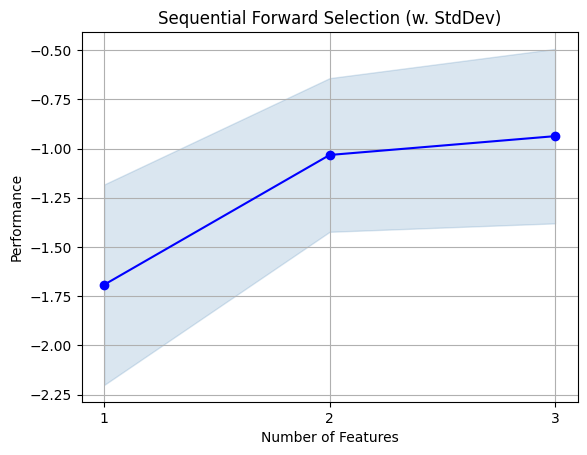

In [66]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [67]:
rfe_sfs_pipeline  = MlExperiment('rfs_feature_selection', EXPERIMENT_NAME, preprocessor_sklearn, regressor)
rfe_sfs_pipeline.pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_sfs_idx)),
    ('model', regressor)
])
rfe_sfs_pipeline.model_fit(X_train, y_train)
rfe_sfs_pipeline.model_predict(X_test, y_test)
rfe_sfs_pipeline.metrics


/Users/flash/Прог Pyt/LR_IIS/LR1/.venv_lr1/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (224). n_quantiles is set to n_samples.
  warnings.warn(


{'mae': 0.8686639687659707,
 'mape': 0.17025242699674814,
 'mse': 2.5066825733344733}

In [68]:
rfe_sfs_pipeline.start_run(signature, input_example, art)

Registered model 'car_model_rf' already exists. Creating a new version of this model...
2024/11/19 13:04:43 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: car_model_rf, version 5
Created version '5' of model 'car_model_rf'.
2024/11/19 13:04:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run rfs_feature_selection at: http://127.0.0.1:5000/#/experiments/1/runs/9d86151ef4e04be8a44d861ef465879a.
2024/11/19 13:04:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


#### HYPERPARAMS

Gridsearch

### Поиск лучших параметров модели

In [69]:
from sklearn.model_selection import  GridSearchCV

In [70]:
param_grid = {
    'model__max_depth': [i for i in range(1,10)],
    'model__n_estimators':[i for i in range(1,5)],
    'model__max_features':[i/10 for i in range(1,10)]
}

In [83]:
gs = GridSearchCV(rfe_skl_pipeline.pipeline, param_grid, cv=2, scoring='neg_mean_absolute_error')
gs.fit(X_train, y_train)


/Users/flash/Прог Pyt/LR_IIS/LR1/.venv_lr1/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (112). n_quantiles is set to n_samples.
  warnings.warn(
/Users/flash/Прог Pyt/LR_IIS/LR1/.venv_lr1/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (112). n_quantiles is set to n_samples.
  warnings.warn(
/Users/flash/Прог Pyt/LR_IIS/LR1/.venv_lr1/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (112). n_quantiles is set to n_samples.
  warnings.warn(
/Users/flash/Прог Pyt/LR_IIS/LR1/.venv_lr1/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (112). n_quantiles is set to n_samples.
  warnings.warn(
/Users/flash/Прог Pyt/LR_IIS/LR1

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Present_Price',
                                                                          'Driven_kms',
                                                                          'Owner']),
                                                                        ('cat',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=99999999),
                                                                         ['Car_Name',
                                                                          'Year',
                                                                          'Fuel_Type',
                                                                          'Selling_type',
                                                                          'Transmission',
                                                                          'mileage_level']),
                                                                        ('quantile',
                                                                         QuantileTransformer(),...
                                                                          'Driven_kms']),
                                                                        ('spline',
                                                                         SplineTransformer(n_knots=3),
                                                                         ['Driven_kms'])])),
                                       ('rfe_extractor',
                                        <__main__.ColumnExtractor object at 0x1682948d0>),
                                       ('model', RandomForestRegressor())]),
             param_grid={'model__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'model__max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                                 0.7, 0.8, 0.9],
                         'model__n_estimators': [1, 2, 3, 4]},
             scoring='neg_mean_absolute_error')

In [84]:
print("Лучшие гиперпараметры:", gs.best_params_)

Лучшие гиперпараметры: {'model__max_depth': 6, 'model__max_features': 0.8, 'model__n_estimators': 4}


In [97]:
regressor_optimized = RandomForestRegressor(max_depth=5, max_features=0.8, n_estimators=4)
rfe_skl_pipeline_optimised  = MlExperiment('rfe_feature_selection_optimised_GridSearchSV', EXPERIMENT_NAME, preprocessor_sklearn,regressor_optimized)
rfe_skl_pipeline_optimised.pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_idx)),
    ('model', regressor_optimized)
])
rfe_skl_pipeline_optimised.model_fit(X_train, y_train)
rfe_skl_pipeline_optimised.model_predict(X_test, y_test)


/Users/flash/Прог Pyt/LR_IIS/LR1/.venv_lr1/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (224). n_quantiles is set to n_samples.
  warnings.warn(


In [98]:
rfe_skl_pipeline_optimised.metrics

{'mae': 0.8301947391343824,
 'mape': 0.21343041111009636,
 'mse': 2.6604253642812377}

In [75]:
rfe_skl_pipeline_optimised.pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Present_Price',
                                                   'Driven_kms', 'Owner']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Car_Name', 'Year',
                                                   'Fuel_Type', 'Selling_type',
                                                   'Transmission',
                                                   'mileage_level']),
                                                 ('quantile',
                                                  QuantileTransformer(),
                                                  ['Present_Price',
                                                   'Driven_kms', 'Owner']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Present_Price',
                                                   'Driven_kms']),
                                                 ('spline',
                                                  SplineTransformer(n_knots=3),
                                                  ['Driven_kms'])])),
                ('rfe_extractor',
                 <__main__.ColumnExtractor object at 0x16972d390>),
                ('model',
                 RandomForestRegressor(max_depth=7, max_features=0.9,
                                       n_estimators=4))])

In [76]:
rfe_skl_pipeline_optimised.start_run(signature, input_example, art)

Registered model 'car_model_rf' already exists. Creating a new version of this model...
2024/11/19 13:04:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: car_model_rf, version 6
Created version '6' of model 'car_model_rf'.
2024/11/19 13:04:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run rfe_feature_selection_optimised_GridSearchSV at: http://127.0.0.1:5000/#/experiments/1/runs/59858825be5a4b5e8b4dad324c907e4f.
2024/11/19 13:04:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


#### Optuna

In [77]:
import optuna

In [78]:
def objective(trial):
    # предлагаем гиперпараметры
    depth = trial.suggest_int('depth', 1, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1)

    # создаём и обучаем модель
    opt_pipeline  = Pipeline(steps=[
        ('preprocessor', preprocessor_sklearn), 
        ('rfe_extractor', ColumnExtractor(rfe_sfs_idx)),
        ('model', CatBoostRegressor(depth=depth, learning_rate=learning_rate, verbose=0))
    ])

    opt_pipeline.fit(X_train, y_train)

    # предсказываем и вычисляем RMSE
    preds = opt_pipeline.predict(X_test)
    mae =  mean_absolute_error(y_test, preds)   

    return mae

In [79]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# выводим результаты
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params) 

[I 2024-11-19 13:04:51,044] A new study created in memory with name: no-name-e0b282a6-ce91-4a6d-a0a3-a603eeb78ca0
/Users/flash/Прог Pyt/LR_IIS/LR1/.venv_lr1/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (224). n_quantiles is set to n_samples.
  warnings.warn(
[I 2024-11-19 13:04:51,656] Trial 0 finished with value: 0.9926720004570604 and parameters: {'depth': 9, 'learning_rate': 0.04386101033468977}. Best is trial 0 with value: 0.9926720004570604.
/Users/flash/Прог Pyt/LR_IIS/LR1/.venv_lr1/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (224). n_quantiles is set to n_samples.
  warnings.warn(
[I 2024-11-19 13:04:51,737] Trial 1 finished with value: 0.9498297652456571 and parameters: {'depth': 2, 'learning_rate': 0.05091957692291506}. Best is trial 1 with value: 0.9498297652456571.
/Users/flash/Прог 

Number of finished trials: 10
Best trial: {'depth': 2, 'learning_rate': 0.05091957692291506}


In [80]:
optuna_model  = MlExperiment('optuna_model', EXPERIMENT_NAME, preprocessor_sklearn, regressor)
optuna_model.pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_sfs_idx)),
    ('model', CatBoostRegressor(depth=8, learning_rate=0.0499305))
])
optuna_model.model_fit(X_train, y_train)
optuna_model.model_predict(X_test, y_test)
optuna_model.pipeline


/Users/flash/Прог Pyt/LR_IIS/LR1/.venv_lr1/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (224). n_quantiles is set to n_samples.
  warnings.warn(


0:	learn: 4.7042901	total: 158us	remaining: 158ms
1:	learn: 4.5815470	total: 414us	remaining: 207ms
2:	learn: 4.4656539	total: 893us	remaining: 297ms
3:	learn: 4.3454264	total: 1.04ms	remaining: 259ms
4:	learn: 4.2373333	total: 1.27ms	remaining: 254ms
5:	learn: 4.1301864	total: 1.71ms	remaining: 283ms
6:	learn: 4.0220851	total: 2.13ms	remaining: 302ms
7:	learn: 3.9163575	total: 2.53ms	remaining: 313ms
8:	learn: 3.8248584	total: 2.91ms	remaining: 321ms
9:	learn: 3.7395649	total: 3.23ms	remaining: 320ms
10:	learn: 3.6446319	total: 3.48ms	remaining: 313ms
11:	learn: 3.5723534	total: 3.72ms	remaining: 306ms
12:	learn: 3.4924316	total: 4.19ms	remaining: 318ms
13:	learn: 3.4015487	total: 4.44ms	remaining: 312ms
14:	learn: 3.3257345	total: 4.84ms	remaining: 318ms
15:	learn: 3.2860467	total: 4.95ms	remaining: 304ms
16:	learn: 3.2154403	total: 5.1ms	remaining: 295ms
17:	learn: 3.1410068	total: 5.26ms	remaining: 287ms
18:	learn: 3.0776373	total: 5.41ms	remaining: 279ms
19:	learn: 3.0126450	total

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Present_Price',
                                                   'Driven_kms', 'Owner']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Car_Name', 'Year',
                                                   'Fuel_Type', 'Selling_type',
                                                   'Transmission',
                                                   'mileage_level']),
                                                 ('quantile',
                                                  QuantileTransformer(),
                                                  ['Present_Price',
                                                   'Driven_kms', 'Owner']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Present_Price',
                                                   'Driven_kms']),
                                                 ('spline',
                                                  SplineTransformer(n_knots=3),
                                                  ['Driven_kms'])])),
                ('rfe_extractor',
                 <__main__.ColumnExtractor object at 0x169bcdc50>),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x169bcc9d0>)])

In [81]:
optuna_model.metrics

{'mae': 0.9481055765802108,
 'mape': 0.206056534580714,
 'mse': 3.468414014540982}

In [82]:
optuna_model.start_run(signature, input_example, art)

Registered model 'car_model_rf' already exists. Creating a new version of this model...
2024/11/19 13:04:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: car_model_rf, version 7
Created version '7' of model 'car_model_rf'.
2024/11/19 13:04:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run optuna_model at: http://127.0.0.1:5000/#/experiments/1/runs/2fc94968889e419c87c027f7aec6c6e1.
2024/11/19 13:04:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


### Лучшая модель

In [8]:
df = pd.read_pickle("../data/car_data_edited.pkl")
df = df.rename(columns={'Selling_Price': 'target'})



In [9]:
Y = df['target']
X = df.drop('target', axis=1)



In [12]:
X

/Users/flash/proga/LR_IIS/LR1/.venv/lib/python3.9/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,Car_Name,Year,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner,mileage_level
0,ritz,2014,5.589844,27000,Petrol,Dealer,Manual,0,mid
1,sx4,2013,9.539062,43000,Diesel,Dealer,Manual,0,mid
2,ciaz,2017,9.851562,6900,Petrol,Dealer,Manual,0,low
3,wagon r,2011,4.148438,5200,Petrol,Dealer,Manual,0,low
4,swift,2014,6.871094,42450,Diesel,Dealer,Manual,0,mid
...,...,...,...,...,...,...,...,...,...
296,city,2016,11.601562,33988,Diesel,Dealer,Manual,0,mid
297,brio,2015,5.898438,60000,Petrol,Dealer,Manual,0,high
298,city,2009,11.000000,87934,Petrol,Dealer,Manual,0,high
299,city,2017,12.500000,9000,Diesel,Dealer,Manual,0,low


In [102]:
rfe_skl_pipeline  = MlExperiment('rfe_feature_selection', EXPERIMENT_NAME, preprocessor_sklearn, regressor)
rfe_skl_pipeline.pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_idx)),
    ('model', regressor)
])
rfe_skl_pipeline.model_fit(X, Y)
rfe_skl_pipeline.model_predict(X, Y)
rfe_skl_pipeline.pipeline

/Users/flash/Прог Pyt/LR_IIS/LR1/.venv_lr1/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (299). n_quantiles is set to n_samples.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Present_Price',
                                                   'Driven_kms', 'Owner']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Car_Name', 'Year',
                                                   'Fuel_Type', 'Selling_type',
                                                   'Transmission',
                                                   'mileage_level']),
                                                 ('quantile',
                                                  QuantileTransformer(),
                                                  ['Present_Price',
                                                   'Driven_kms', 'Owner']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Present_Price',
                                                   'Driven_kms']),
                                                 ('spline',
                                                  SplineTransformer(n_knots=3),
                                                  ['Driven_kms'])])),
                ('rfe_extractor',
                 <__main__.ColumnExtractor object at 0x169733510>),
                ('model', RandomForestRegressor())])

In [103]:
rfe_skl_pipeline.start_run(signature, input_example, art)


Registered model 'car_model_rf' already exists. Creating a new version of this model...
2024/11/19 13:10:13 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: car_model_rf, version 8
Created version '8' of model 'car_model_rf'.
2024/11/19 13:10:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run rfe_feature_selection at: http://127.0.0.1:5000/#/experiments/1/runs/6a47301a3d8e4885acbba1fca6b66e7e.
2024/11/19 13:10:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [104]:
import pickle

In [105]:
model_prod = "model_prod.pkl"  

with open(model_prod, 'wb') as file:  
    pickle.dump(rfe_skl_pipeline.pipeline, file)